# Zeitreihen-Analyse: DTW und Clustering

---
### Table of Contents

- Preparing and Examples
    - [Vorbereitung: Laden und Anzeigen der Daten](#Vorbereitung:-Laden-und-Anzeigen-der-Daten-)
    - [Beispiel für Visualisierung Dynamic Time Warping (DTW)](#Beispiel-für-Visualisierung-Dynamic-Time-Warping-(DTW))
- [Aufgabe 1](#Aufgabe-1:-Clustering-der-Zeitreihen-(2-Punkte))
- [Aufgabe 2](#Aufgabe-2:-Clustering-mit-kMeans-direkt-auf-den-Zeitreihen-(3-Punkte))
    - [Implementierung der Visualiserung](#Implementierung-der-Visualiserung)
    - [Euklidische Variante](#Euklidische-Variante)
    - [DTW Variante](#DTW-Variante)
- [Aufgabe 3](#Aufgabe-3:-Feature-basiertes-Clustering-(6-Punkte))
    - [Auswahl der Features](#Auswahl-der-Features)
    - [Implementierung der Glättung](#Implementierung-der-Glättung)
    - [Feature-Extrtaction-Methoden](#Implementierung-der-Funktionen-für-die-Feature-Extraction)
    - [Features extrahieren und KMeans clustern lassen](#Features-extrahieren-und-KMeans-clustern-lassen)
- [Aufgabe 4](#Aufgabe-4:-Diskussion-des-Ergebnisses-(4-Punkte))

<br>

> *Hinweis: Klicken Sie sich zu den jeweiligen Abteilen. Die dort vorhandenen Überschriften bringen sie mit einem Klick wieder  hier hin, wo Sie von neuem weiter navigieren können.*

<br>

---
### [Vorbereitung: Laden und Anzeigen der Daten](#Zeitreihen-Analyse:-DTW-und-Clustering) <!--[<a style="float:right;margin-right: 10%">Up</a>](#Zeitreihen-Analyse:-DTW-und-Clustering)-->

In [20]:
import os
import math
from copy import deepcopy

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy.signal import find_peaks, peak_widths

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

**Laden der Daten**

In [21]:
directory = "./data/Time_Series/"
mySeries = []
names = []
os.listdir(directory)
for filename in os.listdir(directory):    
    df = pd.read_csv(os.path.join(directory, filename))
    df = df.loc[:,["date","value"]]    
    df.set_index("date",inplace=True)    
    df.sort_index(inplace=True)
    mySeries.append(df)
    names.append(filename[:-4])

**Visualisierung der Zeitreihen**

In [22]:
def plotTimeSeries(seriesList, seriesNames, title, nCols=4): 
    nRows = int(math.ceil(len(seriesList) / nCols))
    fig, axs = plt.subplots(nRows, nCols, figsize=(25,25))
    fig.suptitle(title, fontsize = 30, y = 0.95)
    for i in range(nRows):
        for j in range(nCols):
            idx = i*nCols + j
            if idx >= len(seriesList): 
                continue
            axs[i, j].plot(seriesList[idx].values)
            axs[i, j].set_title(seriesNames[idx])

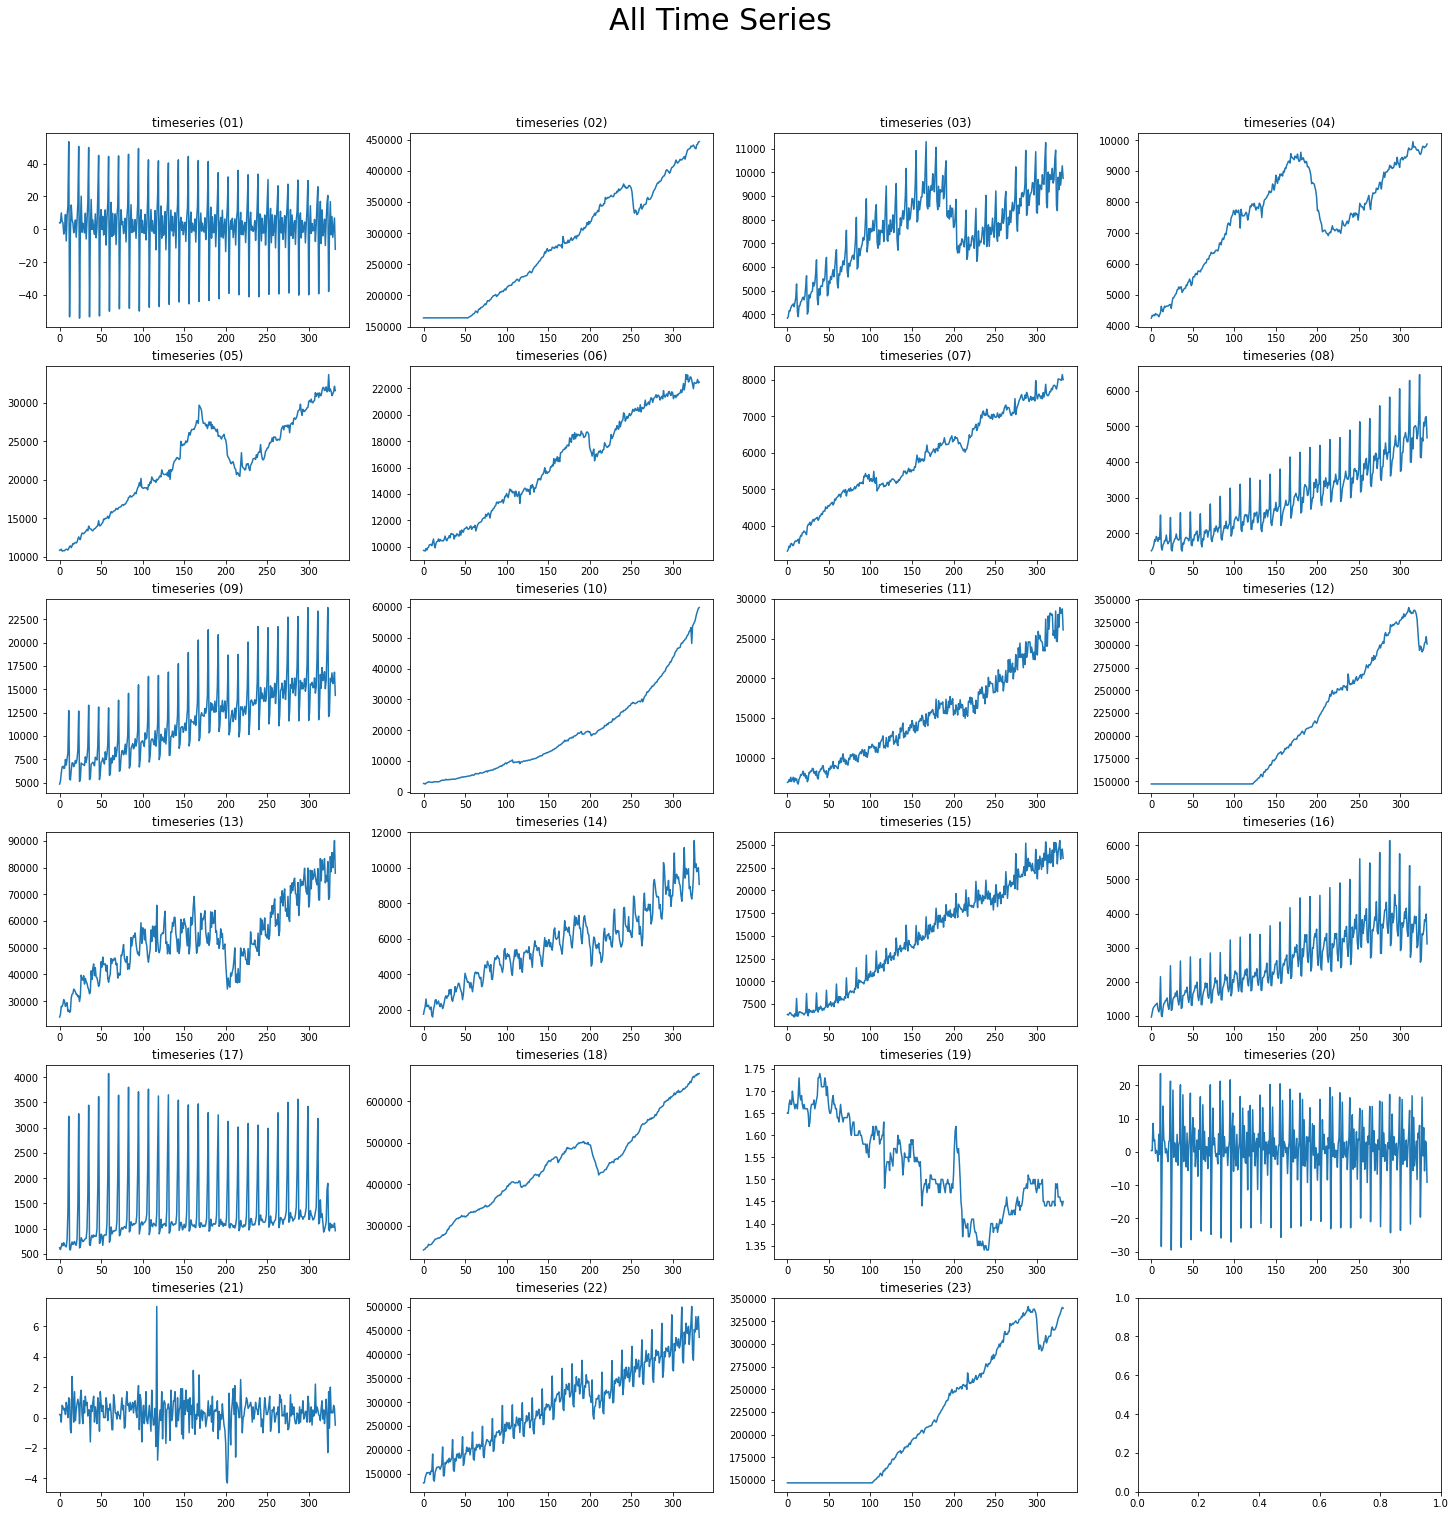

In [23]:
plotTimeSeries(mySeries, names, "All Time Series")

-------
### [Beispiel für Visualisierung Dynamic Time Warping (DTW)](#Zeitreihen-Analyse:-DTW-und-Clustering)

Im Folgenden wird die Library ``dtw`` verwendet.  
Weitere Infromationen und Dokumentationen zu der Library finden Sie unter https://dynamictimewarping.github.io, bzw. in der [API Doc](https://dynamictimewarping.github.io/py-api/html/) zu dtw-python.

In [24]:
from sklearn.preprocessing import MinMaxScaler
from dtw import *

Die Library erwartet, dass die Werte der Zeitreihe zwischen 0 und 1 liegen. 

In [25]:
# NORMALISIERUNG
# Achtung: Bei diesem Schritt geht der Datumsindex verloren. Falls dieser später benötigt wird, 
# muss der Code entsprechend angepasst werden.
mySeries_copy = mySeries.copy()
for i in range(len(mySeries_copy)):
    scaler = MinMaxScaler()
    mySeries_copy[i] = MinMaxScaler().fit_transform(mySeries_copy[i])
    mySeries_copy[i] = mySeries_copy[i].reshape(len(mySeries_copy[i]))

Beispielhafte Visualisierung des DTW-Mappings für zwei der Zeitreihen. 

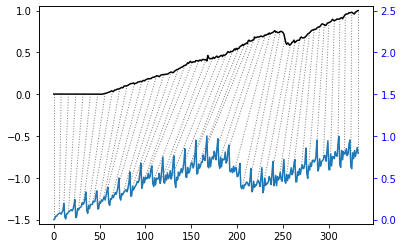

<AxesSubplot:>

In [26]:
dtw(mySeries_copy[1], mySeries_copy[2], keep_internals = True, 
    step_pattern = rabinerJuangStepPattern(6,"c")).plot(type="twoway", offset = -1.5)

-------------------------
### [Aufgabe 1: Clustering der Zeitreihen (2 Punkte)](#Zeitreihen-Analyse:-DTW-und-Clustering)
Ziel des Übungsblattes ist es, die oben geladenen Zeitreihen sinnvoll zu clustern. Als Clustering-Algorithmus soll k-means verwendet werden.

Gehen Sie davon aus, dass ein Domänenexperte Ihnen folgendes zu den Daten bzw. den aus seiner Sicht erwarteten Clustern mitteilt: 
* der Trend spielt eine wichtige Rolle, d.h. Zeitreihen ohne klaren Trend unterscheiden sich aus Sicht des Domänenexperten deutlich von denen mit Trend
* bei den Zeitreihen mit Trend macht es aus Sicht des Domänenexperten einen großen Unterschied, ob es einen klaren Einbruch gibt oder nicht
* die Stärke der Fluktuationen spielt hingegen beim Vergleich der Zeitreihen für ihn keine große Rolle. 

Wie Sie wissen, findet k-means in jedem Fall die gewünschte Anzahl Cluster. Welche Cluster gefunden werden, hängt aber nicht nur von der Einstellung des Parameters *k* ab, sondern auch davon, wie Sie die Daten in einem Feature-Vektor repräsentieren und welche Distanzfunktion Sie verwenden. Die Hinweise des Domänenexperten sind daher wichtig für Sie, um diesbezüglich überhaupt informiert eine Entscheidung treffen zu können und so die Chance zu erhöhen, dass Sie aus Domänensicht "sinnvolle" Cluster bekommen.

Sie haben folgende 3 Alternativen:
1. Die Zeitreihe wird direkt als Feature-Vektor verwendet und es wird mittels der Euklidischen Distanz der Abstand zwischen zwei Zeitreihen berechnet. 
2. Die Zeitreihe wird direkt als Feature-Vektor verwendet und es wird mittels Dynamic Time Warping (DTW) der Abstand zwischen zwei Zeitreihen berechnet. 
3. Es werden zunächst relevante Features aus den Zeitreihen berechnet und der Abstand zwischen zwei Zeitreihen wird anschließend basierend auf dem so erzeugten Feature-Vektor mit der Euklidischen Distanz berechnet. 

Überlegen Sie, welche Vor- und Nachteile Sie - gegeben die vorliegende Aufgabe - bei den 3 Varianten jeweils sehen. Stellen Sie Ihre Überlegungen nachvollziehbar dar. 

Tipp: Sie können unter Umständen ein besseres Gefühl für DTW bekommen, wenn Sie zunächst wie oben gezeigt einige Sequenzpaare und deren Mapping in DTW visualisieren.


-> Zeitverschiebung bei der Domaine wichtig?<br>
-> Wie wichtig ist die Verschiebung auf der X-Achse? Erfordert Domainenwissen?
<br>

- **Ansatz 1:** (Euklidische Distanz)
    - Vorteile:
        - Erkennbar, ob eine Kerbe existiert (nur bedingt, siehe Nachteil)
    - Nachteile:
        - kann nicht mit Zeitverschiebung umgehen -> da es keine Vorverarbeitungsschritte unternimmt
        - Trend nicht so gut abbildbar. Kann nur sehen, ob Trend ähnlich ist oder nicht -> keine Details zu dem Trend.
        - Erfordert Normalisierungsschritt -> wenn die X-Achsen-Verschiebung egal sein sollte
        - Durch Zeitverschiebung Kerbe eventuell nicht mehr erkennbar -> haltet gleiche Kerbe für 2 Kerben

<br>

- **Ansatz 2:** (DTW)
    - Vorteile:
        - Zeitverschiebung ist kein Problem
        - Erkennbar, ob eine Kerbe existiert
    - Nachteile:
        - Trend nicht so gut abbildbar. Kann nur sehen, ob Trend ähnlich ist oder nicht -> keine Details zu dem Trend.
        - Erfordert Normalisierungsschritt -> wenn die X-Achsen-Verschiebung egal sein sollte 
        - 2 gänzlich unterschiedliche Zeitreihen werden stark manipuliert um

<br>

- **Ansatz 3:** (Features Extrahieren)
    - Vorteile:
        - Features kontrollierbar -> so die Vorstellungen von Domaineexperte realisierbar -> Bsp. Steigung
        - Trend gut abbildbar -> Ähnlichkeit + Existiert Trend + Max Steigung + Mean Steigung + Min Steigung + Anzahl an Spitzen
        - Kerbe bei Trend erkennbar
        - Kann mit Zeitverschiebung umgehen, da es nicht die einzelnen Positionen verwendet, sondern die Eigenschaften herauszieht
    - Nachteile:
        - Erfordert Normalisierungsschritt -> wenn die X-Achsen-Verschiebung egal sein sollte
            -> jenachdem welche Features berechnet werden
        - Zu starke Fluktuationen können Probleme verursachen -> Number of Peaks -> Glättung der Daten hilft!

------------------------
### [Aufgabe 2: Clustering mit kMeans direkt auf den Zeitreihen (3 Punkte)](#Zeitreihen-Analyse:-DTW-und-Clustering)

Wenden Sie nun k-means einmal mit der Euklidischen Distanz und einmal mit DTW auf den Zeitreihen an. Da es im von scikit-learn zur Verfügung gestellten Code für k-means nicht möglich ist, eine Metrik einzustellen, verwenden wir hierfür ``TimeSeriesKMeans`` aus dem Package ``tslearn``. 

Plotten Sie anschließend die beiden Ergebnisse, indem Sie die Zeitreihen entsprechend Ihrer Cluster-Zugehörigkeit einfärben. (Verwenden Sie dafür eine Matrix-Darstellung wie oben im Beispielcode gezeigt.)


#### [**Implementierung der Visualiserung**](#Zeitreihen-Analyse:-DTW-und-Clustering)

2 Arten der Visualisierung:
* Alle Datensätze einzelt, dabei werden die Datensätze nach ihren Clustern geplottet
* Alle Datensätze, welche dem selben Cluster zugeordnet wurden, werden in einem Plot geplottet<br>

Dabei können mehrere Parameter gewählt werden, sehr interessant sind die Glättungsverfahren. Hierbei habe ich 2 implementiert, welche beide interessante Resultate erzeugen.

In [27]:
def get_all_indexes_of_cluster(labels, cluster):
    all_in_cluster = labels == cluster
    index_list = []
    for i, value in enumerate(all_in_cluster):
        if value:
            index_list += [i]
    return index_list

def plotTimeSeriesResults(data, names, labels, columns=4, normalize=False, smoothing=False, smooth_args=(16, np.mean, "2")):
    data = deepcopy(data)
    const_column = columns
    # normalize
    if normalize:
        scaler = MinMaxScaler()
        for dataset_nr in range(len(data)):
            data[dataset_nr] = pd.DataFrame(scaler.fit_transform(data[dataset_nr]), columns=data[dataset_nr].columns)

    # smoothing
    if smoothing:
        data = smoothing_all_data(data, *smooth_args)

    for cluster in range(0, max(labels)+1):
        #cur_datasets = data[labels == cluster]
        #cur_names = names[labels == cluster]
        title = f"Cluster {cluster}"
        columns = const_column

        all_indexes_of_cluster = get_all_indexes_of_cluster(labels, cluster)
        print(f"Search Cluster {cluster}. Found:{all_indexes_of_cluster}")

        if len(all_indexes_of_cluster) < const_column:
            columns = len(all_indexes_of_cluster)
            rows = 1
        else:
            rows = int(math.ceil(len(all_indexes_of_cluster)/columns))
        fig, ax = plt.subplots(rows, columns, figsize=(6*columns, 5*rows))
        plt.style.use('seaborn-whitegrid')

        y = 0.94
        if rows == 1:
            y += 0.1
        elif rows == 2:
            y += 0.05
        elif rows == 3:
            y += 0.025
            
        fig.suptitle(title, fontsize=46, y=y) 
    
        plot_nr = 0
        for row in range(rows):
            for col in range(columns):
                try:
                    index_of_data = all_indexes_of_cluster[plot_nr]
                except IndexError:
                    break

                if rows > 1 and columns > 1:
                    #ax[row, col].get_xaxis().set_visible(False)
                    #ax[row, col].set_ylabel("Domain")
                    ax[row, col].set_xlabel(f"Time")
                    ax[row, col].set_title(names[index_of_data])
                    ax[row, col].plot(data[index_of_data].values)
                elif rows == 1 and columns == 1:
                    ax.set_xlabel(f"Time")
                    ax.set_title(names[index_of_data])
                    ax.plot(data[index_of_data].values)
                elif rows == 0 and columns == 0:
                    print("Nothing to draw")
                else:
                    #ax[plot_nr].get_xaxis().set_visible(False)
                    #ax[plot_nr].set_ylabel("Domain")
                    ax[plot_nr].set_xlabel(f"Time")
                    ax[plot_nr].set_title(names[index_of_data])
                    ax[plot_nr].plot(data[index_of_data].values)
            
                plot_nr += 1
                plt.subplots_adjust(wspace=0.1)
        #plt.show()

In [28]:
def plotTimeSeriesResultsInOne(data, names, labels, columns=4, normalize=True, smoothing=False, smooth_args=(16, np.mean, "2")):
    data = deepcopy(data)
    # normalize
    if normalize:
        scaler = MinMaxScaler()
        for dataset_nr in range(len(data)):
            data[dataset_nr] = pd.DataFrame(scaler.fit_transform(data[dataset_nr]), columns=data[dataset_nr].columns)

    # smoothing
    if smoothing:
        data = smoothing_all_data(data, *smooth_args)

    for cluster in range(0, max(labels)+1):
        #cur_datasets = data[labels == cluster]
        #cur_names = names[labels == cluster]
        title = f"Cluster {cluster}"

        all_indexes_of_cluster = get_all_indexes_of_cluster(labels, cluster)
        print(f"Search Cluster {cluster}. Found:{all_indexes_of_cluster}")

        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        plt.style.use('seaborn-whitegrid')

        y = 0.96
        #if rows == 1:
        #    y += 0.2
        fig.suptitle(title, fontsize=46, y=y) 
    
        plot_nr = 0
        for i in all_indexes_of_cluster:
            try:
                index_of_data = all_indexes_of_cluster[plot_nr]
            except IndexError:
                break

            ax.set_xlabel(f"Time")
            ax.plot(data[index_of_data].values)
        
            plot_nr += 1
            plt.subplots_adjust(wspace=0.1)

In [29]:
def plotTimeSeriesResultsMatrixColoring(seriesList, seriesNames, title, clustering, nCols=4):
    nRows = int(math.ceil(len(seriesList) / nCols))
    fig, axs = plt.subplots(nRows, nCols, figsize=(25,25))
    fig.suptitle(title, fontsize = 30, y = 0.95)
    for i in range(nRows):
        for j in range(nCols):
            idx = i*nCols + j
            if idx >= len(seriesList): 
                continue
            if clustering[idx] == 0:
                color = "blue"
            elif clustering[idx] == 1:
                color = "green"
            elif clustering[idx] == 2:
                color = "orange"
            axs[i, j].plot(seriesList[idx].values, c=color)
            axs[i, j].set_title(seriesNames[idx])

#### [**Euklidische Variante**](#Zeitreihen-Analyse:-DTW-und-Clustering)

In [30]:
from tslearn.clustering import TimeSeriesKMeans

In [31]:
model = TimeSeriesKMeans(metric="euclidean").fit(mySeries_copy)

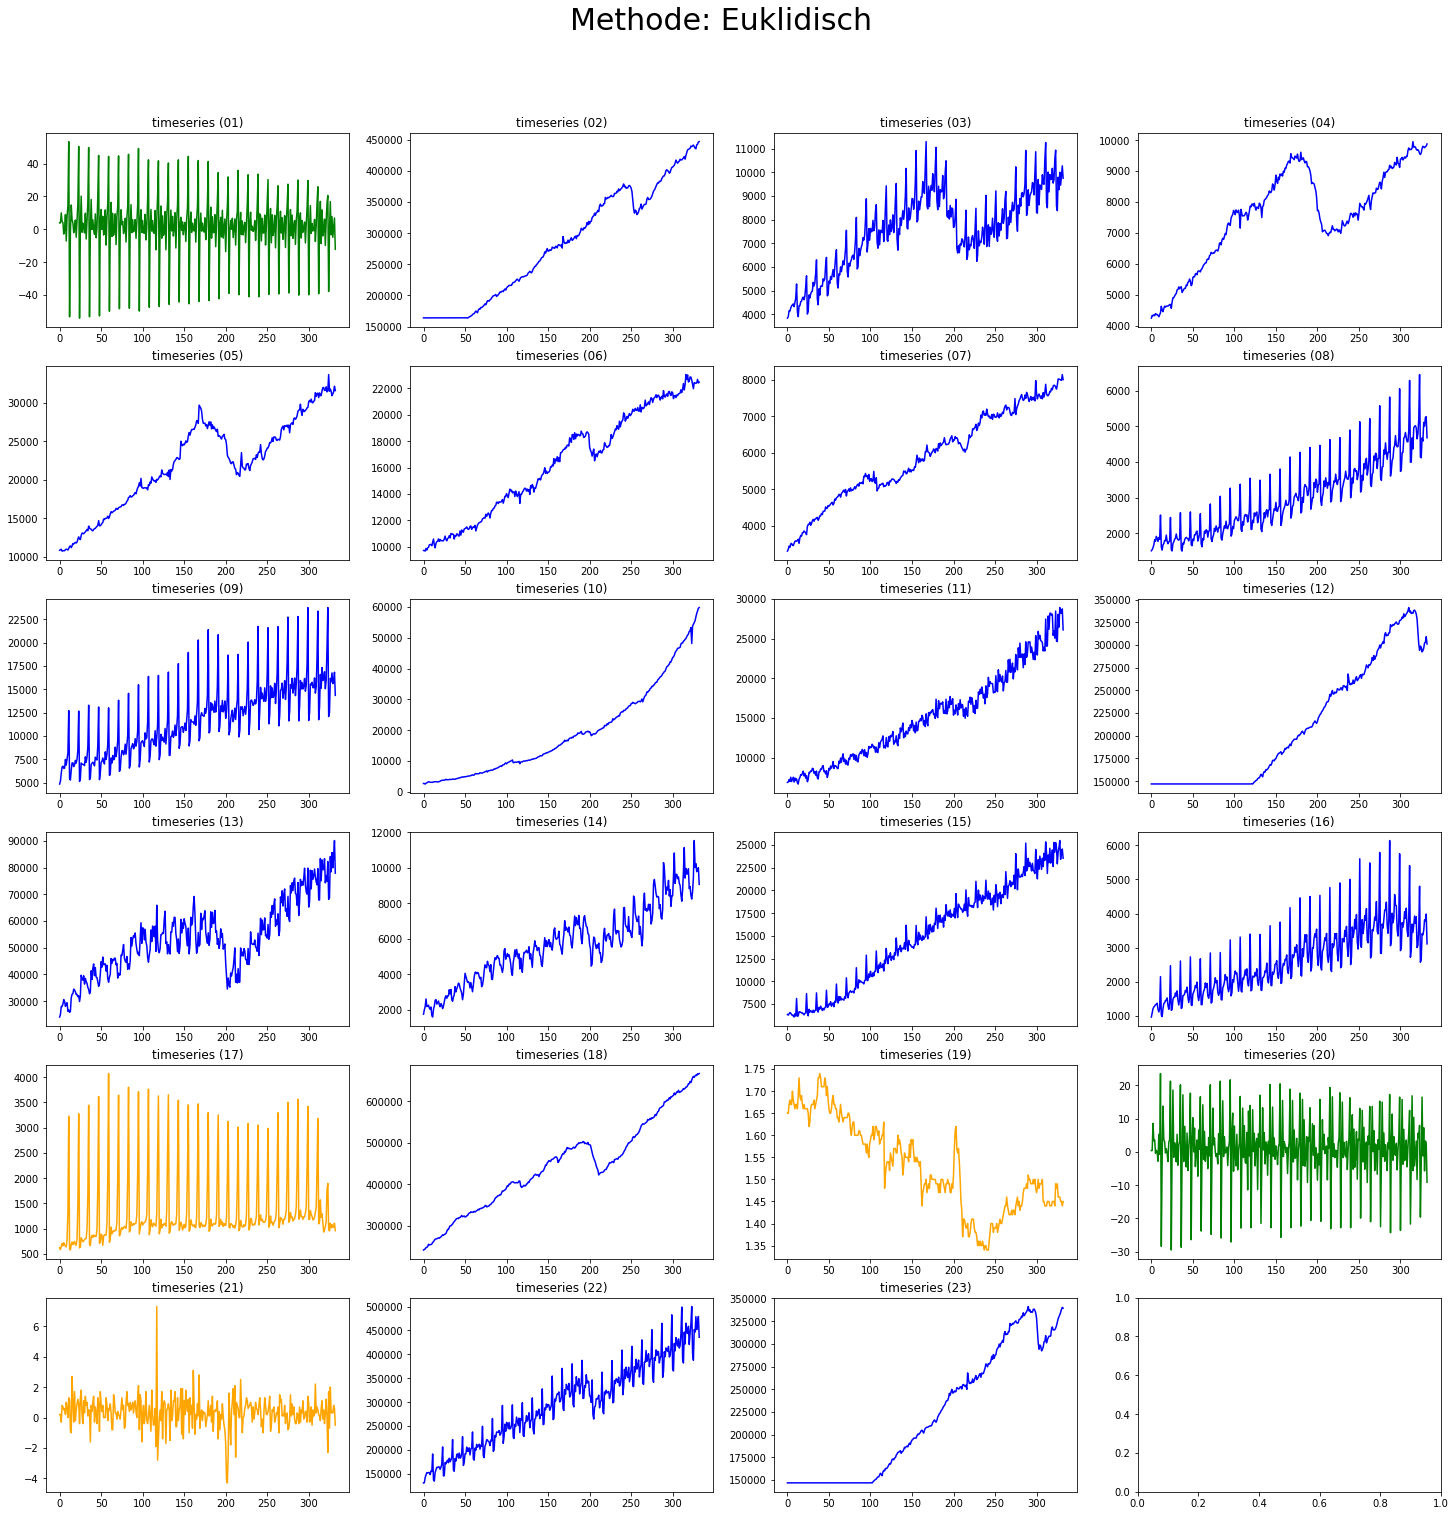

In [32]:
#print("Methode: Euklidisch")
#plotTimeSeriesResults(mySeries, names, model.labels_, columns=4)
plotTimeSeriesResultsMatrixColoring(mySeries, names, "Methode: Euklidisch", model.labels_, nCols=4)

In [33]:
# Alternative
#plotTimeSeriesResultsInOne(mySeries, names, model.labels_, columns=4, smoothing=True, smooth_args=(10, np.median,"2"))

#### [**DTW Variante**](#Zeitreihen-Analyse:-DTW-und-Clustering)

In [34]:
model = TimeSeriesKMeans(metric="dtw").fit(mySeries_copy)

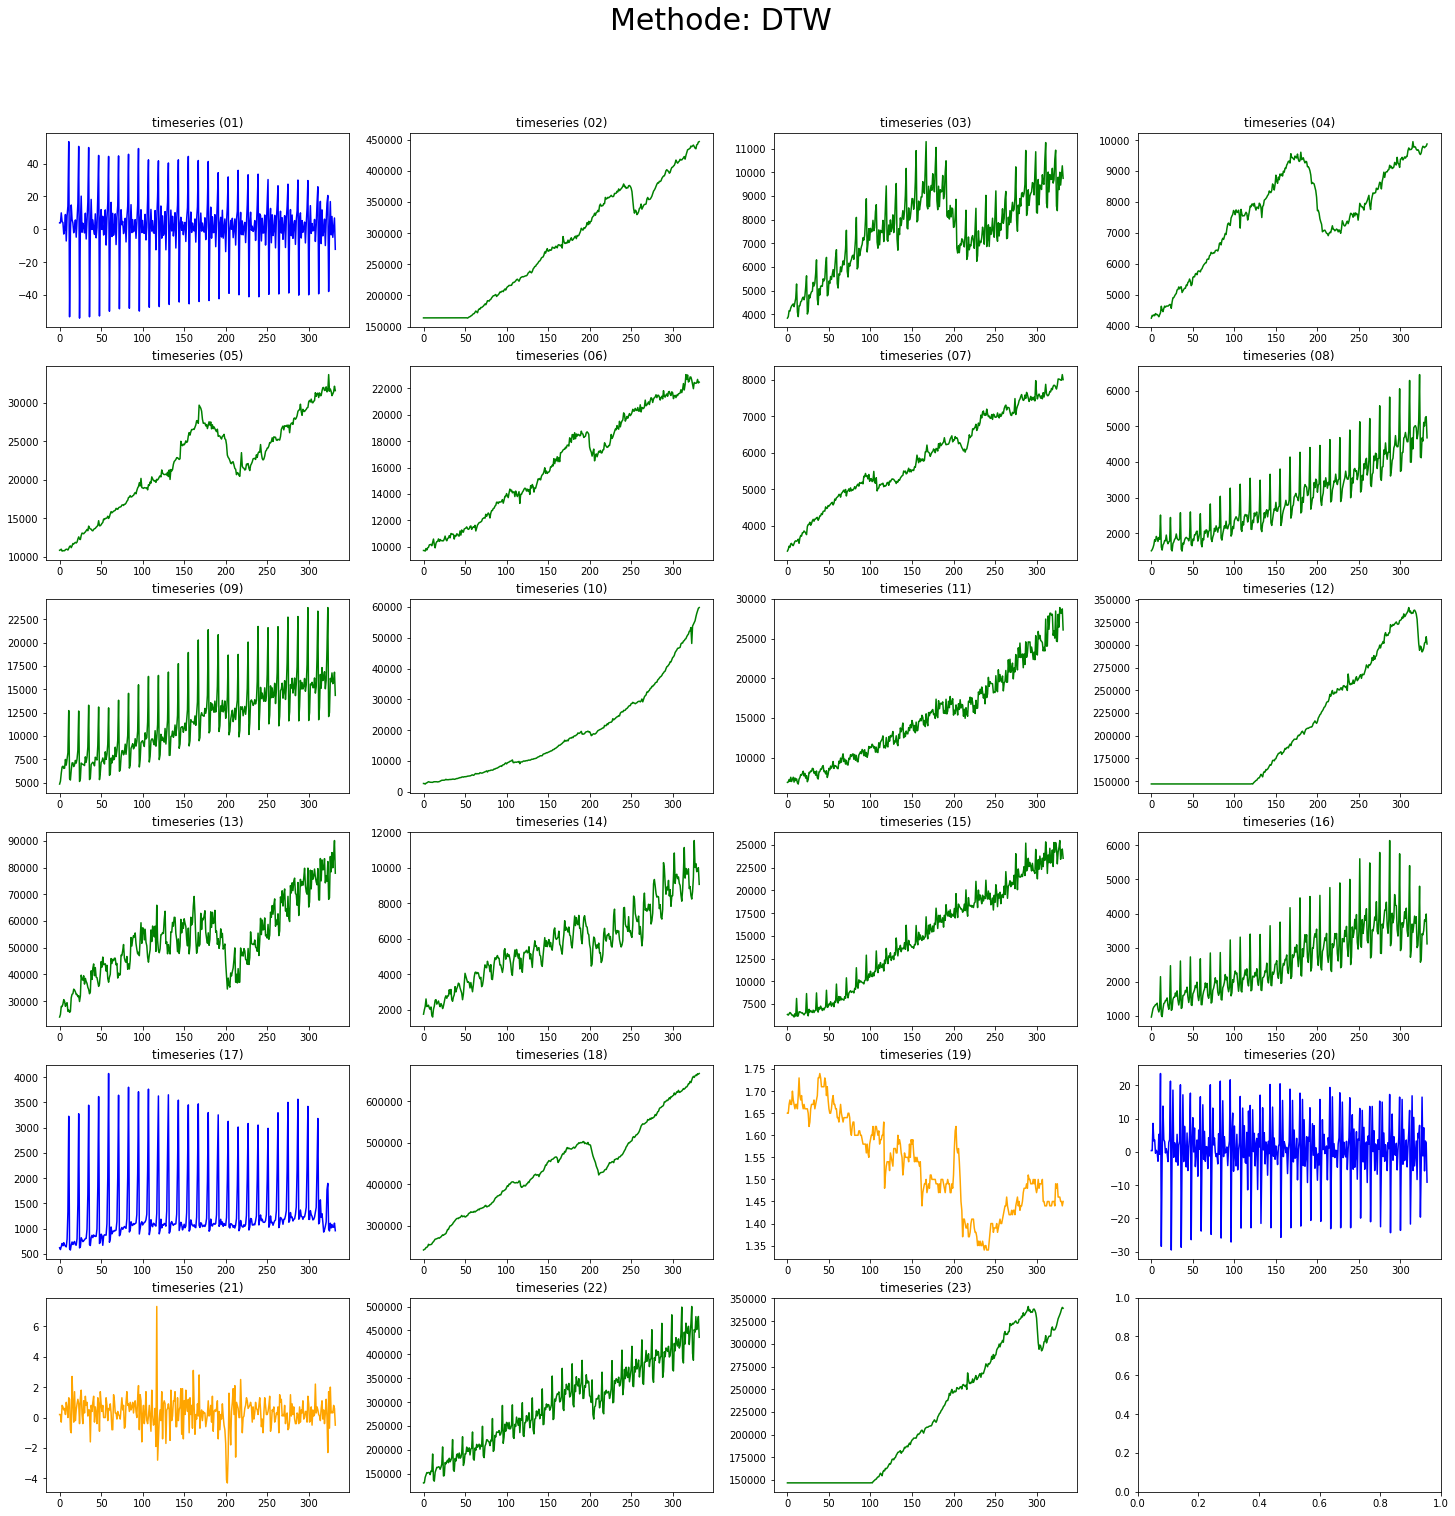

In [35]:
#print("Methode: DTW")
#plotTimeSeriesResults(mySeries, names, model.labels_, columns=4)
plotTimeSeriesResultsMatrixColoring(mySeries, names, "Methode: DTW", model.labels_, nCols=4)

In [36]:
# Alternative
#plotTimeSeriesResultsInOne(mySeries, names, model.labels_, columns=4, smoothing=True, smooth_args=(10, np.median,"2"))

------------------------
### [Aufgabe 3: Feature-basiertes Clustering (6 Punkte)](#Zeitreihen-Analyse:-DTW-und-Clustering)

Extrahieren Sie nun gezielt Features aus den Zeitreihen, so dass die Hinweise des Domänenexperten möglichst gut berücksichtigt werden. 

Zur Feature-Extraktion haben Sie zwei Möglichkeiten: <br>
*a)* Sie überlegen sich, welche Features sinnvoll sein könnten und extrahieren diese manuell. <br> 
*b)* Sie verwenden das Package ``tsfresh`` für die Feature-Extraktion. Da k-means allerdings weder mit irrelevanten Features noch mit hochdimensionalen Daten umgehen kann, muss zusätzliche noch eine gezielte Auswahl von Features stattfinden. Sie können hier eine manuelle Feature-Selektion durchführen oder ggf. die Ihnen bekannten Feature-Selektionsmethoden verwenden.
Weitere Informationen zur Anwendung von ``tsfresh`` finden Sie hier: https://tsfresh.readthedocs.io/en/latest/text/quick_start.html 

Berechnen Sie anschließend das k-means Clustering auf die bekannte Art und Weise. (Jetzt können Sie auch die Version in scikit-learn verwenden). Plotten Sie wieder das Ergebnis durch Einfärbung der Matrix. 



#### [**Auswahl der Features**](#Zeitreihen-Analyse:-DTW-und-Clustering)

Nach der Einschätzung des Domainenexperten resultieren 3 Cluster. Einmal eine Trennung in: hat einen Trend und hat keinen Trend. Wobei sich die Datensätze mit Trend nochmals, durch das Vorhandensein eines Peaks in negativer Richtung, splittet.<br>
Es sollte also 2 essentielle Features geben, anhand derrer die Cluster gebildet werden sollten. Eine Glättung der Daten wäre sehr sinnvoll, da die Fluktuationen keine Rolle spiele, so der Domainenexperte/in und die Wichtigen Muster wären eventuell besser erkennbar.<br>
- Existiert ein Trend
    - Da uns durch ein/e Domainenexperte/in dieser Hinweis gegeben wurde, sollte der Trend aufjedenfall beachtet werden
- Existiert ein Peak in negativer Richtung (wenn Trend existiert)
    - Da uns durch ein/e Domainenexperte/in dieser Hinweis gegeben wurde, sollte der Peak nach unten in die Bewertung einfließen
    - Schwierigkeit ist hierbei: ab wann zählt ein Einbruch als klar ersichtlich? Dies würde ich an dieser Stelle mit dem/der Domainenexperten/in klären.

#### [**Implementierung der Glättung**](#Zeitreihen-Analyse:-DTW-und-Clustering)

- Version 1: Bewegt ein Frame immer x Schritte über die Daten und Glättet alle Werte in einem Frame gleich
    - Example: Daten=[1, 2, 3, 4, 5, 6, 7, 8, 9],  Framegröße=3, Funktion=Median
        1. [1, 2, 3, 4, 5, 6, 7, 8, 9]
        2. [[1, 2, 3], 4, 5, 6, 7, 8, 9]
        3. [[2, 2, 2], 4, 5, 6, 7, 8, 9]
        4. [2, 2, 2, [4, 5, 6], 7, 8, 9]
        5. [2, 2, 2, [5, 5, 5], 7, 8, 9]
        6. ...
        <br>
<br>

- Version 2: Bewegt ein Frame über jeden Punkt (außer über die ersten und letzten) und Glättet jeden Punkt anhand der Nachbarn
    - Example: Daten=[6, 2, 4, 8, 7, 9, 3, 1, 5],  Framegröße=3, Funktion=Median
        1. [6, 2, 4, 8, 7, 9, 3, 1, 5]
        2. [[6, 2, 4], 8, 7, 9, 3, 1, 5]
        3. [[6, 4, 4], 8, 7, 9, 3, 1, 5]
        4. [6, [4, 4, 8], 7, 9, 3, 1, 5]
        5. [6, [4, 4, 8], 7, 9, 3, 1, 5]
        6. [6, 4, [4, 8, 7], 9, 3, 1, 5]
        7. [6, 4, [4, 7, 7], 9, 3, 1, 5]
        8. [6, 4, 4, [7, 7, 9], 3, 1, 5]
        9. ...

In [37]:
def smoothing_1(data, neighbors=3, func=np.median, should_smoothing_before=False, times_smoothing=1):
    # falls noch nicht column reingegeben wurde:
    if type(data) == pd.core.frame.DataFrame:
        data = data.values

    # kopiere data -> soll ohne Seiteneffekt statfinden
    data = data.copy()

    # remove fluctuations before
    if should_smoothing_before:
        for i in range(times_smoothing):
            data = smoothing_2(data, neighbors=neighbors, func=np.median)

    # falls nicht teilbar -> später anfangen -> anfang wird dann nicht geglättet -> *nachbaranzahl besser ändern
    startpoint = 0
    #while (len(data)-startpoint)%neighbors != 0:
    #    startpoint += 1
    while len(data)%neighbors != 0:
        neighbors -= 1

    for smoothing_area_start_index in range(startpoint, len(data), neighbors):
        # hole alle Punkte, welche geglättet werden sollen
        points = []
        for i in range(neighbors):
            points += [data[smoothing_area_start_index+i]]
        # bilde glättungswert
        smooth_number = func(points)
        # Überschreibe neue Werte
        for i in range(neighbors):
            data[smoothing_area_start_index+i] = smooth_number
    return data

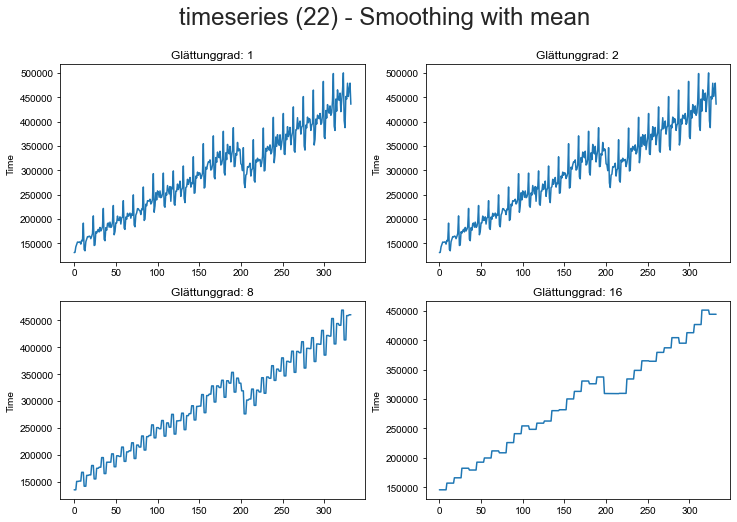

In [38]:
# Smoothing Example
# >> Feel free to change these 3 Values <<
index_of_data = 21
smoothing_nr = [1,2,8,16]
function = np.mean

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.style.use('seaborn-whitegrid')
fig.suptitle(f"{names[index_of_data]} - Smoothing with {getattr(function, '__name__', 'Unknown')}", fontsize=24, y=0.98)

# 1. plot
data = smoothing_1(mySeries[index_of_data], neighbors=smoothing_nr[0], func=function)
ax[0,0].set_ylabel(f"Time")
ax[0,0].set_title(f"Glättunggrad: {smoothing_nr[0]}")
ax[0,0].plot(data)

# 2. plot
data = smoothing_1(mySeries[index_of_data], neighbors=smoothing_nr[1], func=function)
ax[0,1].set_ylabel(f"Time")
ax[0,1].set_title(f"Glättunggrad: {smoothing_nr[1]}")
ax[0,1].plot(data)

# 3. plot
data = smoothing_1(mySeries[index_of_data], neighbors=smoothing_nr[2], func=function)
ax[1,0].set_ylabel(f"Time")
ax[1,0].set_title(f"Glättunggrad: {smoothing_nr[2]}")
ax[1,0].plot(data)

# 4. plot
data = smoothing_1(mySeries[index_of_data], neighbors=smoothing_nr[3], func=function)
ax[1,1].set_ylabel(f"Time")
ax[1,1].set_title(f"Glättunggrad: {smoothing_nr[3]}")
ax[1,1].plot(data);

In [39]:
# neighbors have to be even -> neighbors calls how many neighbors should be watched
# if not even the function makes +1
def smoothing_2(data, neighbors=2, func=np.median):
    # falls noch nicht column reingegeben wurde:
    if type(data) == pd.core.frame.DataFrame:
        data = data.values

    # neighbors have to be even
    if neighbors%2 != 0:
        neighbors += 1

    # kopiere data -> soll ohne Seiteneffekt statfinden
    data = data.copy()

    for smoothing_area_start_index in range(neighbors//2, len(data)-neighbors//2):
        # hole alle Punkte, welche für glätteung wichtig sind
        points = []
        for i in range(-neighbors//2, neighbors//2):
            points += [data[smoothing_area_start_index+i]]
        # Überschreibe neuen Glättungs-Wert
        data[smoothing_area_start_index] = func(points)
    return data

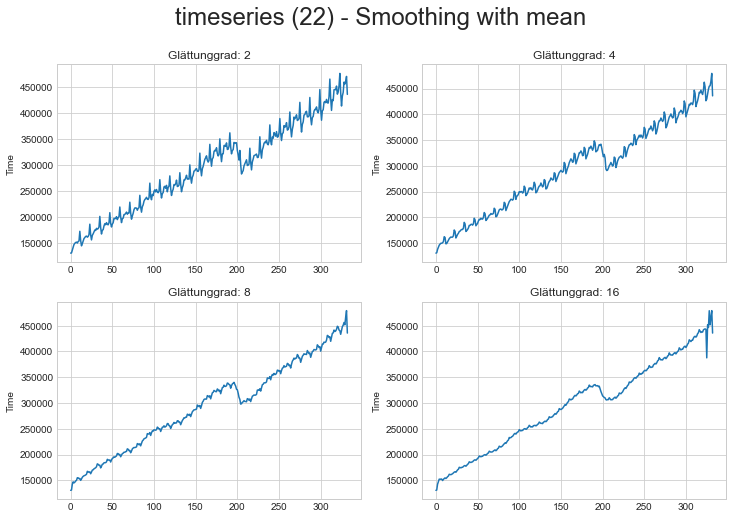

In [40]:
# Smoothing Example
# >> Feel free to change these 3 Values <<
index_of_data = 21
smoothing_nr = [2,4,8,16]
function = np.mean

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
plt.style.use('seaborn-whitegrid')
fig.suptitle(f"{names[index_of_data]} - Smoothing with {getattr(function, '__name__', 'Unknown')}", fontsize=24, y=0.98)

# 1. plot
data = smoothing_2(mySeries[index_of_data], neighbors=smoothing_nr[0], func=function)
ax[0,0].set_ylabel(f"Time")
ax[0,0].set_title(f"Glättunggrad: {smoothing_nr[0]}")
ax[0,0].plot(data)

# 2. plot
data = smoothing_2(mySeries[index_of_data], neighbors=smoothing_nr[1], func=function)
ax[0,1].set_ylabel(f"Time")
ax[0,1].set_title(f"Glättunggrad: {smoothing_nr[1]}")
ax[0,1].plot(data)

# 3. plot
data = smoothing_2(mySeries[index_of_data], neighbors=smoothing_nr[2], func=function)
ax[1,0].set_ylabel(f"Time")
ax[1,0].set_title(f"Glättunggrad: {smoothing_nr[2]}")
ax[1,0].plot(data)

# 4. plot
data = smoothing_2(mySeries[index_of_data], neighbors=smoothing_nr[3], func=function)
ax[1,1].set_ylabel(f"Time")
ax[1,1].set_title(f"Glättunggrad: {smoothing_nr[3]}")
ax[1,1].plot(data);

In [41]:
def smoothing_all_data(data, neighbors=3, func=np.median, version="1"):
    if version == "1":
        smoothing_func = smoothing_1
    else:
        smoothing_func = smoothing_2

    data = deepcopy(data)
    for dataset_nr in range(len(data)):
        data[dataset_nr]["value"] = smoothing_func(data[dataset_nr].values, neighbors, func)
    return data

#### [**Implementierung der Funktionen für die Feature Extraction**](#Zeitreihen-Analyse:-DTW-und-Clustering)

In [42]:
# (nice method)
# my own find peak method -> because the find_peaks mehtod of scipy don't works how i want
# i use a little trick -> i transform the data with smoothing_1 in a 'digital'-likely form
# and use this abstracter form to find the changes
# The presmoothing is to remove the fluctuations
def get_peaks(data, should_smoothing_before=False, times_smoothing=1, normalize=False, min_width=2, min_height=0.2):
    if type(data) == pd.DataFrame:
        data = data.value

    data = data.copy()

    if normalize:
        scaler = MinMaxScaler()
        data = pd.Series(scaler.fit_transform(data), name=data.name)
    
    data = smoothing_1(data, neighbors=8, func=np.mean, should_smoothing_before=should_smoothing_before, times_smoothing=times_smoothing)
    cur_freq = data[0]
    pos_peaks = []
    neg_peaks = []
    tendency = []
    for i, data_point in enumerate(data):
        if data_point == cur_freq:
            # last data_point_check
            #if i == len(data)-1:
            #    if min_width <= tendency[-min_width-1:].count('neg'):
            #        # check height ?
            #        neg_peaks += [i]
            continue
        if data_point < cur_freq:
            # check min-width
            if len(tendency) > min_width and tendency[-min_width:] == ['pos']*min_width:
               # check min-height
                height = []
                # get pointer pos of last neg value
                pointer = i
                counter = min_width
                while counter >= 0:
                    pointer -= 1
                    if data[pointer] != data[pointer+1]:
                        counter -= 1
                    if pointer <= 0:
                        break

                tendency_pointer = -min_width-1
                while tendency[tendency_pointer] == 'pos':
                    if pointer <= 0 or tendency_pointer <= 0:
                        break
                    if data[pointer] != data[pointer-1]:
                        height += [abs(data[pointer] - data[pointer-1])]
                        tendency_pointer -= 1
                    pointer -= 1
                #print(f"height={height}, sum(height)={sum(height)}, sum(height) > min_height={sum(height) > min_height}")   
                if sum(height) > min_height:
                    neg_peaks += [i]
            tendency += ['neg']
        elif data_point > cur_freq:
            if len(tendency) > min_width and tendency[-min_width:] == ['neg']*min_width:
                # check min-height
                height = []
                # get pointer pos of last neg value
                pointer = i-1
                #counter = min_width
                #while counter >= 0:
                    #pointer -= 1
                    #if data[pointer] != data[pointer+1]:
                    #    counter -= 1
                    #if pointer <= 0:
                    #    break

                tendency_pointer = -1
                while tendency[tendency_pointer] == 'neg':
                    if pointer <= 0:
                        break
                    if data[pointer] != data[pointer-1]:
                        height += [abs(data[pointer] - data[pointer-1])]
                        tendency_pointer -= 1
                    pointer -= 1
                #print(f"height={height}, sum(height)={sum(height)}, sum(height) > min_height={sum(height) > min_height}")   
                if sum(height) > min_height:
                    neg_peaks += [i]
            tendency += ['pos']
            
        # last data_point_check
        #if i == len(data)-1:
        #    if min_width <= tendency[-min_width-1:].count('neg'):
                # check height ?
        #        neg_peaks += [i]
        # update cur level
        cur_freq = data_point
    return tendency, pos_peaks, neg_peaks


In [43]:
# like voting classifier
# 2 Systems 
#    1. a Stepsystem, which looks to the trend localy and every local look gives a vote
#    2. duplicate system -> looks how many duplicate values there are
#        -> a function without duplicates have definitly a trend ...
def has_trend(data, should_smoothing_before=False, normalize=False) -> bool:
    #if abs(np.std(data)) > 0.1:
    #    return True
    #else:
    #    return False
    
    if type(data) == pd.DataFrame:
        data = data.value

    data = data.copy()
        
    # smoothing -> fluctuations are trublemakers    
    data = smoothing_2(data, neighbors=20, func=np.mean)
    data = smoothing_2(data, neighbors=10, func=np.mean)

    buffer = 0.0    # no need for a buffer -> if fluctuations are fine (through smoothing)
    step_size = 10
    predictions = {'has_trend':0, 'has_no_trend':0}
    values = []
    duplicates = dict()
    for datapoint_index in range(step_size, len(data), step_size):
        # duplicate-system
        value_buffer = 0.02
        found = False
        for key in duplicates.keys():
            if data[datapoint_index] <= key+value_buffer and data[datapoint_index] >= key-value_buffer:
                duplicates[key] += 1
                found = True
                break
        if not found:    
            duplicates[data[datapoint_index]] = 0

        # localy trend
        #print((data[datapoint_index] - data[datapoint_index-step_size])/(step_size))
        values += [abs((data[datapoint_index] - data[datapoint_index-step_size])/(step_size)) - buffer]
        if abs((data[datapoint_index] - data[datapoint_index-step_size])/(step_size)) - buffer > 0.001:
            predictions['has_trend'] += 1
        else:
            predictions['has_no_trend'] += 1 

    # evaluation of duplicate-system
    #print((sum(duplicates.values()))**2/(25))
    #print(duplicates.keys())
    predictions['has_no_trend'] += (sum(duplicates.values()))**2/(21)

    #print(f"{predictions}, mean:{np.mean(values)}")
    if predictions['has_trend'] > predictions['has_no_trend']:
        return True
    else:
        return False

In [44]:
# normalize! -> all have other scalas -> very difficult
def has_down_peak(data, should_smoothing_before=False, normalize=False, min_width=2, min_height=0.05) -> bool:
    data = data.copy()

    if has_trend(data):
        results = get_peaks(data, should_smoothing_before=should_smoothing_before, times_smoothing=1, normalize=normalize, 
                                                                                   min_width=min_width, min_height=min_height)
        # sort all peaks with negative
        neg_peaks = results[2]
        #neg_peaks = find_peaks(data, prominence=-1, distance=0.2, height=0.9)[0]
        if len(neg_peaks) > 0:
            return True
        else:
            return False
    else:
        return False

In [45]:
# Method for Feature Extrtaction
def extract_features(data, functions:iter, normalize=False):
    """Extracts Features of a timeseries data.
    
    Returns a list of lists"""

    # if argument is boolean instead of list 
    if type(normalize) == bool:
        if normalize:
            normalize = [True]*len(data)
        else:
            normalize = [False]*len(data)

    scaler = MinMaxScaler()
    dataset_features_list = []
    for dataset_nr in range(0, len(data)):
        feature_collection = []
        for i, function in enumerate(functions):
            # Normalize 
            if normalize[i]:
                cur_data = pd.DataFrame(scaler.fit_transform(data[dataset_nr]), columns=data[dataset_nr].columns)
            else:
                cur_data = data[dataset_nr]
            feature_collection += [function(cur_data['value'])]
        dataset_features_list += [feature_collection]
    return dataset_features_list

#### [**Features extrahieren und KMeans clustern lassen**](#Zeitreihen-Analyse:-DTW-und-Clustering)

In [46]:
features = [has_trend, lambda x: has_down_peak(x, should_smoothing_before=False, normalize=False, min_width=2, min_height=0.075)]
data = smoothing_all_data(mySeries, neighbors=16, func=np.mean, version="2")
# normalize
scaler = MinMaxScaler()
for dataset_nr in range(len(data)):
    data[dataset_nr] = pd.DataFrame(scaler.fit_transform(data[dataset_nr]), columns=data[dataset_nr].columns)
extracted_data = extract_features(data, features, normalize=False)
#extracted_data

In [47]:
model = KMeans(n_clusters=3).fit(extracted_data)
model.labels_

array([2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 0,
       0])

**Ergebnis:**

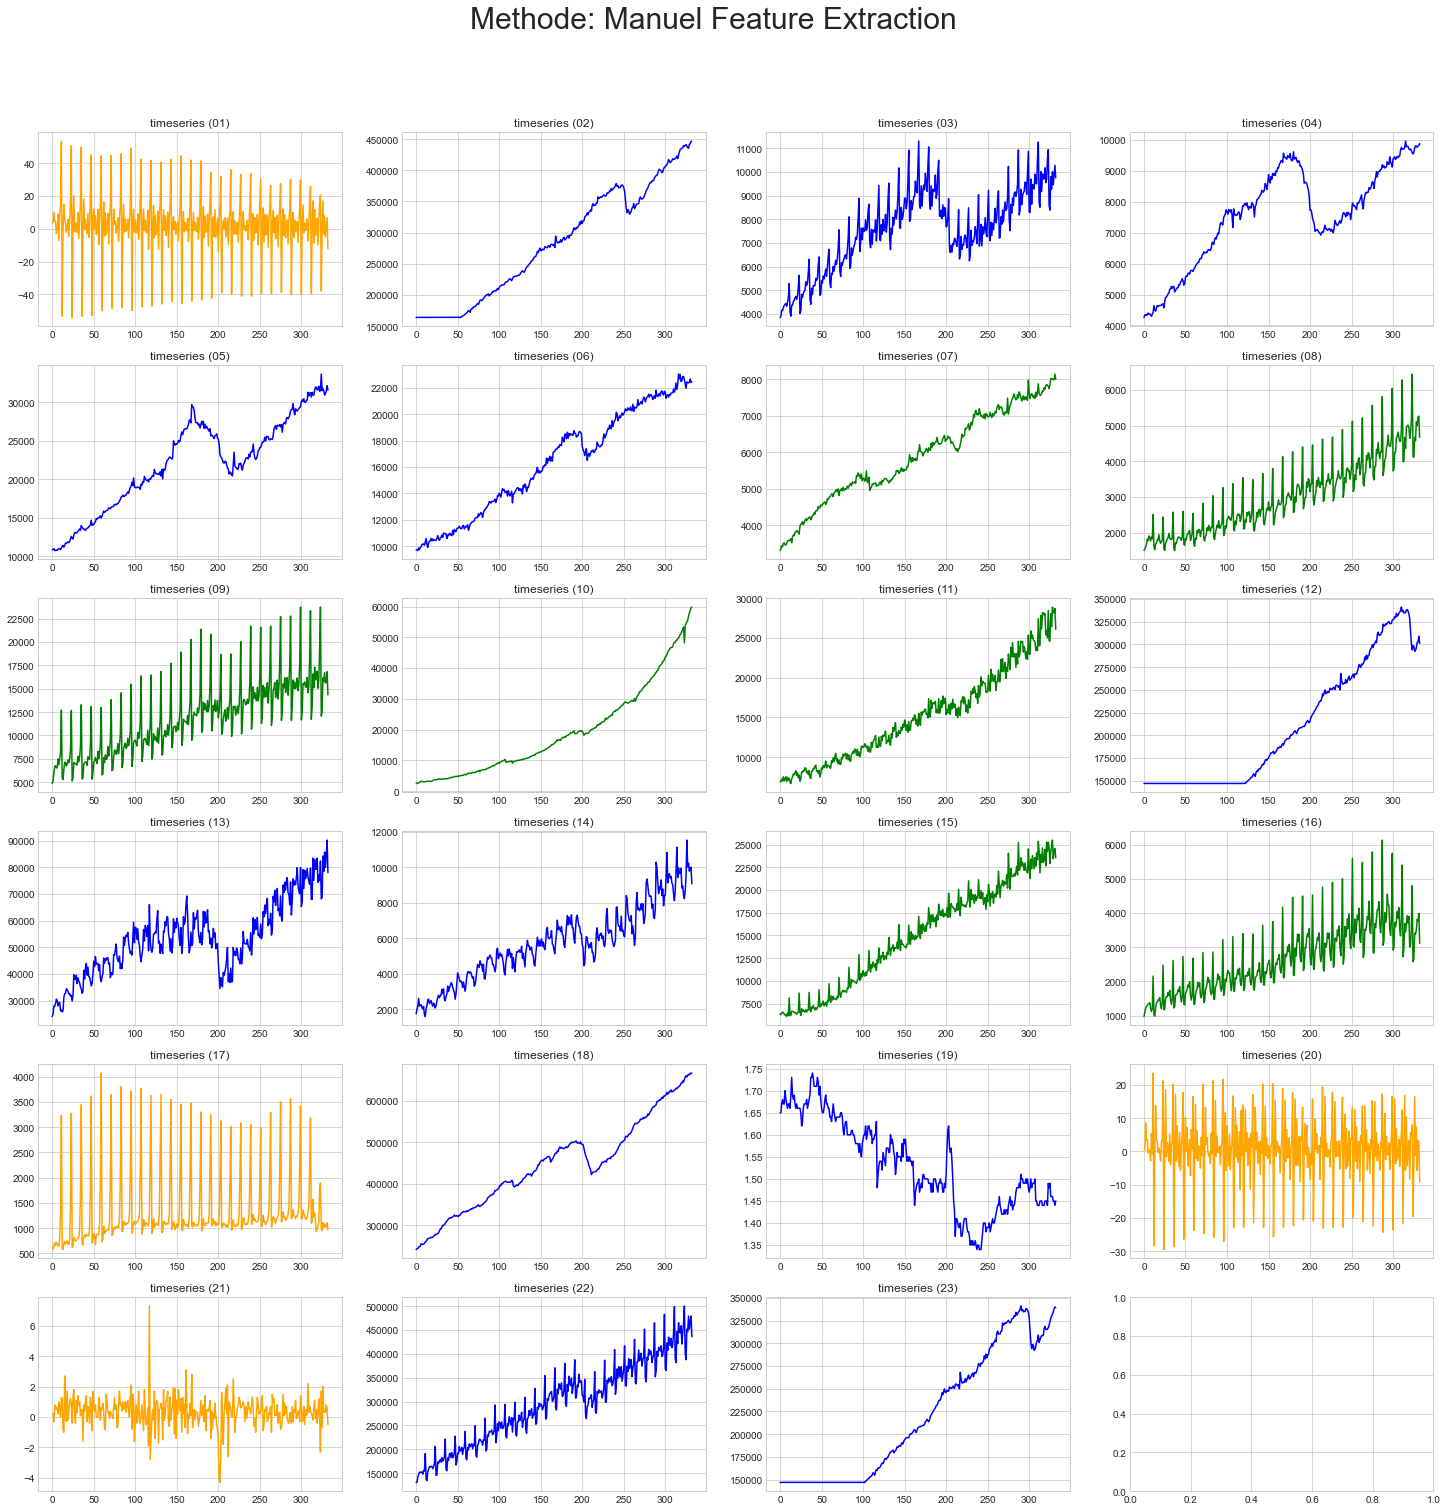

In [48]:
#print("Methode: Manuel Feature Extraction")
#plotTimeSeriesResults(mySeries, names, model.labels_, columns=4, normalize=True, smoothing=False, smooth_args=(10, np.median,"1"))
plotTimeSeriesResultsMatrixColoring(mySeries, names, "Methode: Manuel Feature Extraction", model.labels_, nCols=4)

**Ergebnis-Übersicht:**

Search Cluster 0. Found:[1, 2, 3, 4, 5, 11, 12, 13, 17, 18, 21, 22]
Search Cluster 1. Found:[6, 7, 8, 9, 10, 14, 15]
Search Cluster 2. Found:[0, 16, 19, 20]


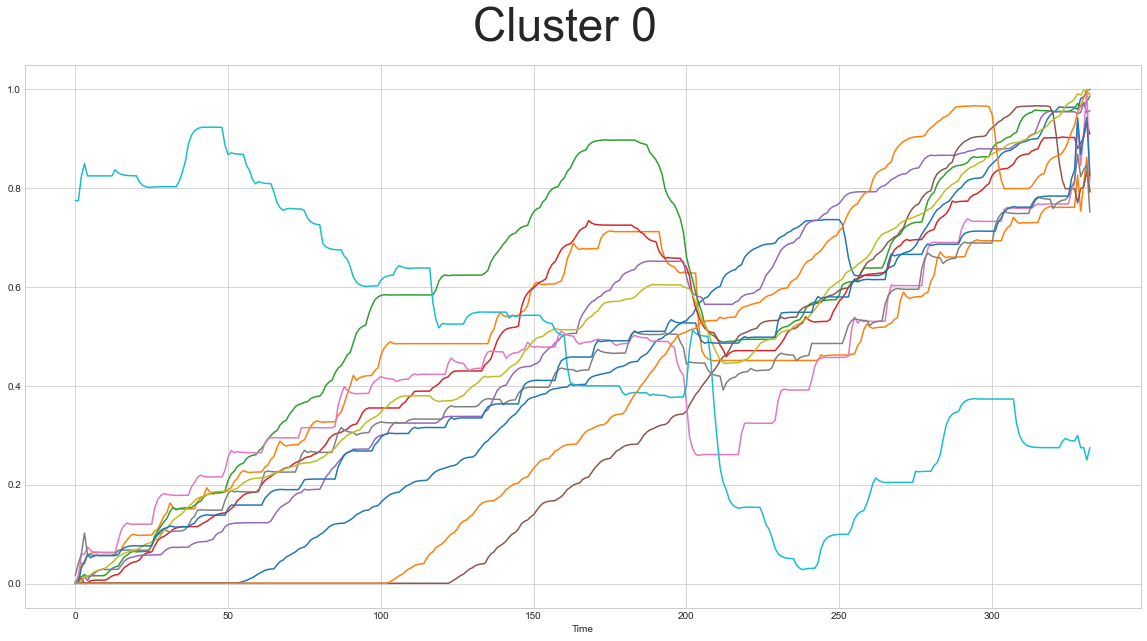

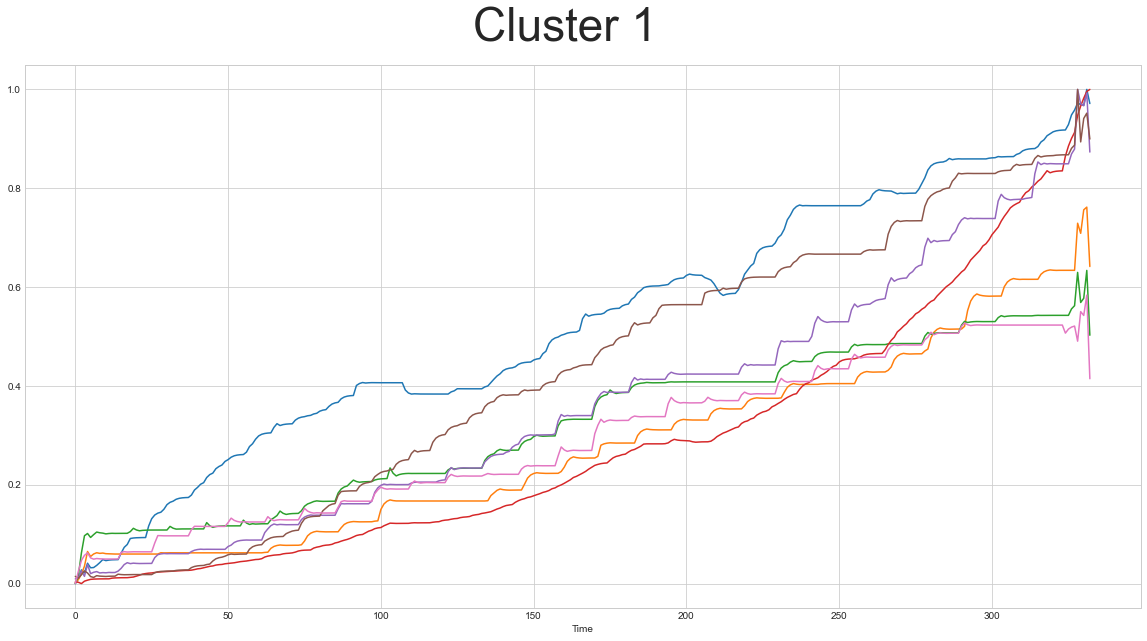

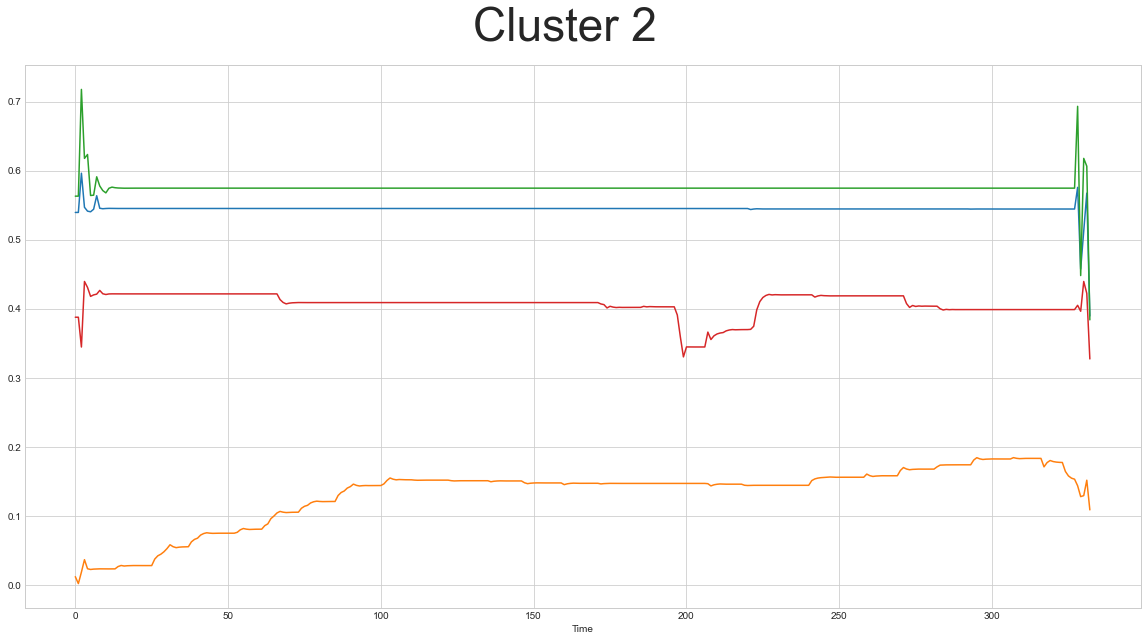

In [49]:
plotTimeSeriesResultsInOne(mySeries, names, model.labels_, columns=4, smoothing=True, smooth_args=(10, np.median,"2"))

### [Aufgabe 4: Diskussion des Ergebnisses (4 Punkte)](#Zeitreihen-Analyse:-DTW-und-Clustering)

Diskutieren Sie die Ergebnisse. Welche Methode hat in diesem Fall am besten funktioniert? Stimmt dies mit Ihren Annahmen in Aufgabe 1 überein? Welche Beobachtungen haben Sie gemacht? Wenn Sie noch mehr Zeit investieren könnten, welche nächsten Schritte würden Sie dann vornehmen? 

Aus meiner Sicht haben meine anfänglichen Überlegungen recht gut mit der Realität übereinstimmt. Als einzigster wirklicher Ausreißer würde ich die Methode mit DTW bennen. Diese konnte weniger gut mit den Daten umgehen, als ich es mir vorgestellt hatte. <br>
Dies könnte eventuell auch daran liegen, dass die Daten sehr unterschiedliche waren (die ähnlichen Daten aus Domainensicht meine ich hier besonders). Die Problemstellung war wahrscheinlich einfach zu komplex für die ersten beiden Methoden. Um genauer zu sein, meine ich damit, dass die definierte Ähnlichkeit, des Domainenexperten, für die ersten beiden Verfahren schwer zu realisieren ist.<br>
<br>
Besonders viel spaß und überzeugt bin ich von der Feature-Basierten Methode. Hier sind einem keinen Grenzen gesetzt und man kann vollkommen auf die Domaine eingehen. Dabei halte ich die mauelle Feature-Extraction für die bessere Wahl, auch wenn Tsfresh gute Ansätze besitzt, so schränken diese einen doch auf eine gewisse Art ein. <br>
Mit den 2 Features: Exist_Trend und Has_Down_Peak konnte das Clustern ganz nach der Beschreibung des Domainenexperten erfolgen. Außerdem wurde der 3. Tipp durch das Glätten der Daten mit einer eigenen Methode bewältigt.<br>
<br>
Sehr viel Zeit habe ich in die [Feature-Extrtaction-Methoden](#Implementierung-der-Funktionen-für-die-Feature-Extraction) gesteckt (get_peaks, has_down_peak, has_trend) und auch das Plotten, sowie das Glätten hat etwas mehr Zeit in Anspruch genommen. Dadurch hat dieses Praktikum mehr Zeit gebraucht als die bisherigen (aber das war ja meine Entscheidung).<br>
Das Ergebnis stellt mich jedoch sehr zufrieden und die Arbeit hat sich gelohnt.<br>
<br>
Während der gesamten Aufgabe stellte sich mir die Frage, was genau mit 'klar ersichtlicher Einruch' gemeint ist, denn es gibt ein paar Datensätze die ich hier nicht sicher einordnen konnte. Im realen Leben, würde ich den/die Domainenexperte/in fragen. Ich denke, aber das meine interpretation recht nah an der realen Lösung dran sein sollte.<br>
<br>
Mehr Zeit würde ich in die ersten beiden Methoden investieren. Dort hätte man mit dem Glätten der Daten und mit den Hyperparametern sicherlich mehr herausholen können.

### Restliche Punkte

\+ 2 Punkte für die übersichtliche Darstellung der Ergebnisse / des Notebooks

\+ 2 Punkte dafür, wenn Sie mit einem der 3 Ansätze ein gutes Ergebnis im Sinn der Einschätzung des Domänenexperten (siehe Aufgabe 1) erzielen